In [1]:
%load_ext rpy2.ipython
%load_ext autoreload
%autoreload 2

%matplotlib inline  
from matplotlib import rcParams
rcParams['figure.figsize'] = (16, 100)

import warnings
from rpy2.rinterface import RRuntimeWarning
warnings.filterwarnings("ignore") # Ignore all warnings
# warnings.filterwarnings("ignore", category=RRuntimeWarning) # Show some warnings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, HTML

In [2]:
%%javascript
// Disable auto-scrolling
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [3]:
%%R

# My commonly used R imports

require('tidyverse')

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.2     ✔ tibble    3.2.1
✔ lubridate 1.9.4     ✔ tidyr     1.3.1
✔ purrr     1.0.4     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


Loading required package: tidyverse


In [4]:
%%R
# Load packages and prepare environment
library(tidyverse)
library(fixest)
library(ggplot2)


In [5]:
%%R
# Load the dataset
df <- read_csv("hmda_2021_2023_with_elections.csv")

# Create binary outcome


Rows: 53810560 Columns: 31
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (5): lei, state_code, county_code, derived_dwelling_category, property_...
dbl (26): activity_year, action_taken, loan_purpose, lien_status, loan_amoun...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


## black versus white in trump majority states for all states 

In [7]:
%%R
library(tidyverse)
library(fixest)

# Updated anti-DEI law signature dates
anti_dei_law_dates <- tribble(
  ~state_code, ~law_date,
  "SD", "2022-03-18",
  "FL", "2022-04-22",
  "TN", "2022-04-08",
  "TX", "2023-03-10",
  "IA", "2023-03-01",
  "ND", "2023-04-24",
  "UT", "2024-01-17",
  "AR", "2023-03-13",
  "NC", "2023-12-05",
  "AL", "2024-03-20",
  "WY", "2024-03-04",
  "KS", "2024-04-19",
  "KY", "2024-03-28",
  "ID", "2024-03-21",
  "OH", "2023-12-19",
  "IN", "2024-01-14",
  "WV", "2025-01-14"
) %>%
  mutate(law_date = as.Date(law_date))

# Prepare dataset
df_clean <- df %>%
  filter(
    loan_purpose == 1,
    derived_dwelling_category == "Single Family (1-4 Units):Site-Built",
    occupancy_type == 1,
    income > 0,
    `applicant_race-1` %in% c(1, 3)  # White = 1, Black = 3
  ) %>%
  mutate(
    approved = ifelse(action_taken %in% c(1, 2, 6), 1, 0),
    debt_to_income = loan_amount / income,
    race = case_when(
      `applicant_race-1` == 1 ~ "White",
      `applicant_race-1` == 3 ~ "Black"
    ),
    activity_date = as.Date(paste0(activity_year, "-01-01"))
  ) %>%
  left_join(anti_dei_law_dates, by = "state_code") %>%
  mutate(
    anti_dei_state = ifelse(!is.na(law_date), 1, 0),
    post_dei_law = ifelse(!is.na(law_date) & activity_date >= law_date, 1, 0),
    trump_majority = factor(ifelse(per_gop > 0.5, 1, 0), levels = c(0, 1))  # Trump-majority is ref
  ) %>%
  filter(is.finite(debt_to_income))

# Model: Interaction of trump_majority, race, and post_dei_law
df_interact <- df_clean %>%
  mutate(race = factor(race, levels = c("White", "Black")))

model_trump_race_post <- feglm(
  approved ~ trump_majority * race * post_dei_law +
    income + loan_amount + debt_to_income |
    activity_year + county_code + lei,
  data = df_interact,
  family = "binomial"
)

cat("\n📌 MODEL: Interaction of Trump Majority, Race, and Post-DEI\n")
summary(model_trump_race_post)



📌 MODEL: Interaction of Trump Majority, Race, and Post-DEI
GLM estimation, family = binomial, Dep. Var.: approved
Observations: 1,639,436
Fixed-effects: activity_year: 3,  county_code: 2,719,  lei: 3,113
Standard-errors: Clustered (activity_year) 
                                           Estimate   Std. Error   z value
raceBlack                              -0.078868566 0.0060243120 -13.09171
post_dei_law                           -0.144993362 0.0097662244 -14.84641
income                                 -0.000215704 0.0000844867  -2.55312
loan_amount                             0.000000612 0.0000000794   7.70834
debt_to_income                         -0.000107797 0.0000132171  -8.15584
trump_majority1:raceBlack              -0.018498775 0.0139417427  -1.32686
trump_majority1:post_dei_law            0.114720083 0.0339909472   3.37502
raceBlack:post_dei_law                  0.121317501 0.0104408683  11.61948
trump_majority1:raceBlack:post_dei_law -0.108331244 0.0130194151  -8.32075
 

NOTES: 78,083 observations removed because of NA values (RHS: 78,083).
       0/250/1,001 fixed-effects (3,909 observations) removed because of only 0 (or only 1) outcomes.
The variable 'trump_majority1' has been removed because of collinearity (see $collin.var).


## black versus white in trump majority states for anti-DEI law states 

In [13]:
%%R
library(tidyverse)
library(fixest)

# Define updated anti-DEI law signature dates
anti_dei_law_dates <- tribble(
  ~state_code, ~law_date,
  "SD", "2022-03-18",
  "FL", "2022-04-22",
  "TN", "2022-04-08",
  "TX", "2023-03-10",
  "IA", "2023-03-01",
  "ND", "2023-04-24",
  "UT", "2024-01-17",
  "AR", "2023-03-13",
  "NC", "2023-12-05",
  "AL", "2024-03-20",
  "WY", "2024-03-04",
  "KS", "2024-04-19",
  "KY", "2024-03-28",
  "ID", "2024-03-21",
  "OH", "2023-12-19",
  "IN", "2024-01-14",
  "WV", "2025-01-14"
) %>%
  mutate(law_date = as.Date(law_date))

# Clean and prepare dataset
df_clean <- df %>%
  filter(
    loan_purpose == 1,
    derived_dwelling_category == "Single Family (1-4 Units):Site-Built",
    occupancy_type == 1,
    income > 0,
    `applicant_race-1` %in% c(1, 3)  # White = 1, Black = 3
  ) %>%
  mutate(
    approved = ifelse(action_taken %in% c(1, 2, 6), 1, 0),
    debt_to_income = loan_amount / income,
    race = case_when(
      `applicant_race-1` == 1 ~ "White",
      `applicant_race-1` == 3 ~ "Black"
    ),
    activity_date = as.Date(paste0(activity_year, "-01-01"))
  ) %>%
  left_join(anti_dei_law_dates, by = "state_code") %>%
  mutate(
    anti_dei_state = ifelse(!is.na(law_date), 1, 0),
    post_dei_law = ifelse(!is.na(law_date) & activity_date >= law_date, 1, 0),
    trump_majority = factor(ifelse(per_gop > 0.5, 1, 0), levels = c(0, 1))  # 0 = non-Trump majority (ref)
  ) %>%
  filter(is.finite(debt_to_income))

# Filter only to anti-DEI states
df_law_states <- df_clean %>%
  filter(anti_dei_state == 1) %>%
  mutate(
    race = factor(race, levels = c("White", "Black"))  # Set White as reference
  )

# Run model: Interaction of Trump majority * Race * Post-DEI law
model_trump_race_post <- feglm(
  approved ~ trump_majority * race * post_dei_law +
    income + loan_amount + debt_to_income |
    activity_year + county_code + lei,
  data = df_law_states,
  family = "binomial",
  control = list(iter_max = 100)  # 👈 increases max iterations
)

# Output summary
cat("\n📌 MODEL: Trump Majority × Race × Post-DEI Law (Within DEI Law States)\n")
summary(model_trump_race_post)



📌 MODEL: Trump Majority × Race × Post-DEI Law (Within DEI Law States)
GLM estimation, family = binomial, Dep. Var.: approved
Observations: 636,965
Fixed-effects: activity_year: 3,  county_code: 1,199,  lei: 1,750
Standard-errors: Clustered (activity_year) 
                                           Estimate   Std. Error   z value
raceBlack                              -0.085617788 0.0079415490 -10.78099
post_dei_law                           -0.201997794 0.0022335425 -90.43830
income                                 -0.000391265 0.0000952519  -4.10769
loan_amount                             0.000000804 0.0000000853   9.42118
debt_to_income                         -0.000138321 0.0000125283 -11.04068
trump_majority1:raceBlack               0.029045606 0.0117351037   2.47510
trump_majority1:post_dei_law            0.158527216 0.0293598358   5.39946
raceBlack:post_dei_law                  0.133826388 0.0109880511  12.17927
trump_majority1:raceBlack:post_dei_law -0.161047212 0.0071477187 -2

NOTES: 6,990 observations removed because of NA values (RHS: 6,990).
       0/143/638 fixed-effects (2,030 observations) removed because of only 0 (or only 1) outcomes.
The variable 'trump_majority1' has been removed because of collinearity (see $collin.var).
In addition: Warning messages:
1: In fixest_env(fml = fml, data = data, family = famil...:
 feglm(fml = app...: control is not a valid argument for function feglm() 
2: Absence of convergence: Maximum number of iterations reached (25). Final deviance: 762,740.9. 


## black versus white in trump majority states for non anti-DEI law states 

no post_dei_law since these states never passed a law

In [11]:
%%R
library(tidyverse)
library(fixest)

# Define anti-DEI law signature dates
anti_dei_law_dates <- tribble(
  ~state_code, ~law_date,
  "SD", "2022-03-18",
  "FL", "2022-04-22",
  "TN", "2022-04-08",
  "TX", "2023-03-10",
  "IA", "2023-03-01",
  "ND", "2023-04-24",
  "UT", "2024-01-17",
  "AR", "2023-03-13",
  "NC", "2023-12-05",
  "AL", "2024-03-20",
  "WY", "2024-03-04",
  "KS", "2024-04-19",
  "KY", "2024-03-28",
  "ID", "2024-03-21",
  "OH", "2023-12-19",
  "IN", "2024-01-14",
  "WV", "2025-01-14"
) %>%
  mutate(law_date = as.Date(law_date))

# Clean and prepare dataset
df_clean <- df %>%
  filter(
    loan_purpose == 1,
    derived_dwelling_category == "Single Family (1-4 Units):Site-Built",
    occupancy_type == 1,
    income > 0,
    `applicant_race-1` %in% c(1, 3)  # White = 1, Black = 3
  ) %>%
  mutate(
    approved = ifelse(action_taken %in% c(1, 2, 6), 1, 0),
    debt_to_income = loan_amount / income,
    race = case_when(
      `applicant_race-1` == 1 ~ "White",
      `applicant_race-1` == 3 ~ "Black"
    ),
    activity_date = as.Date(paste0(activity_year, "-01-01"))
  ) %>%
  left_join(anti_dei_law_dates, by = "state_code") %>%
  mutate(
    anti_dei_state = ifelse(!is.na(law_date), 1, 0),
    trump_majority = factor(ifelse(per_gop > 0.5, 1, 0), levels = c(0, 1))
  ) %>%
  filter(is.finite(debt_to_income))

# Filter only to non-anti-DEI states
df_non_dei_states <- df_clean %>%
  filter(anti_dei_state == 0) %>%
  mutate(
    race = factor(race, levels = c("White", "Black"))  # Set White as reference
  )

# Run model: Trump majority × Race (in non-DEI-law states only)
model_trump_race_nondei <- feglm(
  approved ~ trump_majority * race +
    income + loan_amount + debt_to_income |
    activity_year + county_code + lei,
  data = df_non_dei_states,
  family = "binomial"
)

# Output summary
cat("\n📌 MODEL: Trump Majority × Race (Non-Anti-DEI Law States Only)\n")
summary(model_trump_race_nondei)



📌 MODEL: Trump Majority × Race (Non-Anti-DEI Law States Only)
GLM estimation, family = binomial, Dep. Var.: approved
Observations: 1,001,595
Fixed-effects: activity_year: 3,  county_code: 1,523,  lei: 2,370
Standard-errors: Clustered (activity_year) 
                              Estimate   Std. Error   z value   Pr(>|z|)    
raceBlack                 -0.075331279 0.0054229910 -13.89109  < 2.2e-16 ***
income                    -0.000165357 0.0000698858  -2.36610 1.7976e-02 *  
loan_amount                0.000000539 0.0000000674   7.99398 1.3065e-15 ***
debt_to_income            -0.000094297 0.0000121074  -7.78843 6.7848e-15 ***
trump_majority1:raceBlack -0.070660872 0.0139148293  -5.07810 3.8123e-07 ***
... 1 variable was removed because of collinearity (trump_majority1)
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1
Log-Likelihood:  -590,594.4   Adj. Pseudo R2: 0.046592
           BIC: 1,235,061.6     Squared Cor.: 0.067192


NOTES: 71,093 observations removed because of NA values (RHS: 71,093).
       0/163/831 fixed-effects (2,755 observations) removed because of only 0 (or only 1) outcomes.
The variable 'trump_majority1' has been removed because of collinearity (see $collin.var).


## with post-2022 to 'fake' timesign post 

In [12]:
%%R
library(tidyverse)
library(fixest)

# Define anti-DEI law signature dates
anti_dei_law_dates <- tribble(
  ~state_code, ~law_date,
  "SD", "2022-03-18",
  "FL", "2022-04-22",
  "TN", "2022-04-08",
  "TX", "2023-03-10",
  "IA", "2023-03-01",
  "ND", "2023-04-24",
  "UT", "2024-01-17",
  "AR", "2023-03-13",
  "NC", "2023-12-05",
  "AL", "2024-03-20",
  "WY", "2024-03-04",
  "KS", "2024-04-19",
  "KY", "2024-03-28",
  "ID", "2024-03-21",
  "OH", "2023-12-19",
  "IN", "2024-01-14",
  "WV", "2025-01-14"
) %>%
  mutate(law_date = as.Date(law_date))

# Clean and prepare dataset
df_clean <- df %>%
  filter(
    loan_purpose == 1,
    derived_dwelling_category == "Single Family (1-4 Units):Site-Built",
    occupancy_type == 1,
    income > 0,
    `applicant_race-1` %in% c(1, 3)  # White = 1, Black = 3
  ) %>%
  mutate(
    approved = ifelse(action_taken %in% c(1, 2, 6), 1, 0),
    debt_to_income = loan_amount / income,
    race = case_when(
      `applicant_race-1` == 1 ~ "White",
      `applicant_race-1` == 3 ~ "Black"
    ),
    activity_date = as.Date(paste0(activity_year, "-01-01")),
    post_2022 = ifelse(activity_year >= 2022, 1, 0)
  ) %>%
  left_join(anti_dei_law_dates, by = "state_code") %>%
  mutate(
    anti_dei_state = ifelse(!is.na(law_date), 1, 0),
    trump_majority = factor(ifelse(per_gop > 0.5, 1, 0), levels = c(0, 1))
  ) %>%
  filter(is.finite(debt_to_income))

# Filter only to non-anti-DEI states
df_non_dei_post2022 <- df_clean %>%
  filter(anti_dei_state == 0) %>%
  mutate(
    race = factor(race, levels = c("White", "Black"))  # Set White as reference
  )

# Run model: Trump majority × Race × Post-2022 (non-DEI-law states only)
model_trump_race_post2022 <- feglm(
  approved ~ trump_majority * race * post_2022 +
    income + loan_amount + debt_to_income |
    activity_year + county_code + lei,
  data = df_non_dei_post2022,
  family = "binomial"
)

# Output summary
cat("\n📌 MODEL: Trump Majority × Race × Post-2022 (Non-Anti-DEI Law States Only)\n")
summary(model_trump_race_post2022)



📌 MODEL: Trump Majority × Race × Post-2022 (Non-Anti-DEI Law States Only)
GLM estimation, family = binomial, Dep. Var.: approved
Observations: 1,001,595
Fixed-effects: activity_year: 3,  county_code: 1,523,  lei: 2,370
Standard-errors: Clustered (activity_year) 
                                        Estimate   Std. Error  z value
raceBlack                           -0.089484813 0.0108580443 -8.24134
income                              -0.000165444 0.0000698791 -2.36757
loan_amount                          0.000000539 0.0000000674  8.00125
debt_to_income                      -0.000094321 0.0000121192 -7.78277
trump_majority1:raceBlack           -0.029395301 0.0136729057 -2.14989
trump_majority1:post_2022            0.091004851 0.0091661822  9.92833
raceBlack:post_2022                  0.022592318 0.0068434727  3.30129
trump_majority1:raceBlack:post_2022 -0.064023278 0.0120662904 -5.30596
                                      Pr(>|z|)    
raceBlack                            < 2.2e-16

NOTES: 71,093 observations removed because of NA values (RHS: 71,093).
       0/163/831 fixed-effects (2,755 observations) removed because of only 0 (or only 1) outcomes.
The variables 'trump_majority1' and 'post_2022' have been removed because of collinearity (see $collin.var).


## Democratic-Leaning States black versus white 

In [27]:
%%R
library(tidyverse)
library(fixest)

# Updated anti-DEI law signature dates
anti_dei_law_dates <- tribble(
  ~state_code, ~law_date,
  "SD", "2022-03-18",
  "FL", "2022-04-22",
  "TN", "2022-04-08",
  "TX", "2023-03-10",
  "IA", "2023-03-01",
  "ND", "2023-04-24",
  "UT", "2024-01-17",
  "AR", "2023-03-13",
  "NC", "2023-12-05",
  "AL", "2024-03-20",
  "WY", "2024-03-04",
  "KS", "2024-04-19",
  "KY", "2024-03-28",
  "ID", "2024-03-21",
  "OH", "2023-12-19",
  "IN", "2024-01-14",
  "WV", "2025-01-14"
) %>%
  mutate(law_date = as.Date(law_date))

# Prepare dataset
df_clean <- df %>%
  filter(
    loan_purpose == 1,
    derived_dwelling_category == "Single Family (1-4 Units):Site-Built",
    occupancy_type == 1,
    income > 0,
    `applicant_race-1` %in% c(1, 3)  # White = 1, Black = 3
  ) %>%
  mutate(
    approved = ifelse(action_taken %in% c(1, 2, 6), 1, 0),
    debt_to_income = loan_amount / income,
    race = case_when(
      `applicant_race-1` == 1 ~ "White",
      `applicant_race-1` == 3 ~ "Black"
    ),
    activity_date = as.Date(paste0(activity_year, "-01-01"))
  ) %>%
  left_join(anti_dei_law_dates, by = "state_code") %>%
  mutate(
    anti_dei_state = ifelse(!is.na(law_date), 1, 0),
    post_dei_law = ifelse(!is.na(law_date) & activity_date >= law_date, 1, 0),
    trump_majority = factor(ifelse(per_gop > 0.5, 1, 0), levels = c(0, 1))
  ) %>%
  filter(
    is.finite(debt_to_income),
    per_dem > 0.5  # ✅ Focus on Democratic-leaning areas
  )

# Model: Interaction of trump_majority, race, and post_dei_law in Dem states
df_interact <- df_clean %>%
  mutate(race = factor(race, levels = c("White", "Black")))

model_trump_race_post <- feglm(
  approved ~ trump_majority * race * post_dei_law +
    income + loan_amount + debt_to_income |
    activity_year + county_code + lei,
  data = df_interact,
  family = "binomial"
)

cat("\n📌 MODEL: Trump Majority × Race × Post-DEI Law (Democratic-Leaning States)\n")
summary(model_trump_race_post)



📌 MODEL: Trump Majority × Race × Post-DEI Law (Democratic-Leaning States)
GLM estimation, family = binomial, Dep. Var.: approved
Observations: 1,057,580
Fixed-effects: activity_year: 3,  county_code: 484,  lei: 2,339
Standard-errors: Clustered (activity_year) 
                           Estimate   Std. Error   z value   Pr(>|z|)    
raceBlack              -0.067878718 0.0038119678 -17.80674  < 2.2e-16 ***
post_dei_law           -0.095205724 0.0163764342  -5.81358 6.1150e-09 ***
income                 -0.000165759 0.0000686911  -2.41311 1.5817e-02 *  
loan_amount             0.000000516 0.0000000612   8.42202  < 2.2e-16 ***
debt_to_income         -0.000102600 0.0000101742 -10.08436  < 2.2e-16 ***
raceBlack:post_dei_law  0.084682767 0.0083240928  10.17321  < 2.2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1
Log-Likelihood:  -631,986.7   Adj. Pseudo R2: 0.04623
           BIC: 1,303,229.7     Squared Cor.: 0.06436
# Evaluations: lhs: 25 -- no convergence: Max

NOTE: 0/15/827 fixed-effects (2,447 observations) removed because of only 0 (or only 1) outcomes.
In addition: Warning message:
Absence of convergence: Maximum number of iterations reached (25). Final deviance: 1,263,973.3. 


## black vs white dem states(anti-dei law states only) 

In [14]:
%%R
library(tidyverse)
library(fixest)

# Define updated anti-DEI law signature dates
anti_dei_law_dates <- tribble(
  ~state_code, ~law_date,
  "SD", "2022-03-18",
  "FL", "2022-04-22",
  "TN", "2022-04-08",
  "TX", "2023-03-10",
  "IA", "2023-03-01",
  "ND", "2023-04-24",
  "UT", "2024-01-17",
  "AR", "2023-03-13",
  "NC", "2023-12-05",
  "AL", "2024-03-20",
  "WY", "2024-03-04",
  "KS", "2024-04-19",
  "KY", "2024-03-28",
  "ID", "2024-03-21",
  "OH", "2023-12-19",
  "IN", "2024-01-14",
  "WV", "2025-01-14"
) %>%
  mutate(law_date = as.Date(law_date))

# Clean and prepare dataset
df_clean <- df %>%
  filter(
    loan_purpose == 1,
    derived_dwelling_category == "Single Family (1-4 Units):Site-Built",
    occupancy_type == 1,
    income > 0,
    `applicant_race-1` %in% c(1, 3)
  ) %>%
  mutate(
    approved = ifelse(action_taken %in% c(1, 2, 6), 1, 0),
    debt_to_income = loan_amount / income,
    race = case_when(
      `applicant_race-1` == 1 ~ "White",
      `applicant_race-1` == 3 ~ "Black"
    ),
    activity_date = as.Date(paste0(activity_year, "-01-01"))
  ) %>%
  left_join(anti_dei_law_dates, by = "state_code") %>%
  mutate(
    anti_dei_state = ifelse(!is.na(law_date), 1, 0),
    post_dei_law = ifelse(!is.na(law_date) & activity_date >= law_date, 1, 0),
    trump_majority = factor(ifelse(per_gop > 0.5, 1, 0), levels = c(0, 1))
  ) %>%
  filter(is.finite(debt_to_income))

# ✅ Filter to Democratic-leaning areas (per_dem > 0.5)
df_dem_states <- df_clean %>%
  filter(per_dem > 0.5) %>%
  mutate(
    race = factor(race, levels = c("White", "Black"))
  )

# Run model: Trump Majority × Race × Post-DEI Law
model_trump_race_demstates <- feglm(
  approved ~ trump_majority * race * post_dei_law +
    income + loan_amount + debt_to_income |
    activity_year + county_code + lei,
  data = df_dem_states,
  family = "binomial",
  control = list(iter_max = 100)
)

# Output summary
cat("\n📌 MODEL: Trump Majority × Race × Post-DEI Law (Democratic-Leaning States Only)\n")
summary(model_trump_race_demstates)



📌 MODEL: Trump Majority × Race × Post-DEI Law (Democratic-Leaning States Only)
GLM estimation, family = binomial, Dep. Var.: approved
Observations: 1,057,580
Fixed-effects: activity_year: 3,  county_code: 484,  lei: 2,339
Standard-errors: Clustered (activity_year) 
                           Estimate   Std. Error   z value   Pr(>|z|)    
raceBlack              -0.067878718 0.0038119678 -17.80674  < 2.2e-16 ***
post_dei_law           -0.095205724 0.0163764342  -5.81358 6.1150e-09 ***
income                 -0.000165759 0.0000686911  -2.41311 1.5817e-02 *  
loan_amount             0.000000516 0.0000000612   8.42202  < 2.2e-16 ***
debt_to_income         -0.000102600 0.0000101742 -10.08436  < 2.2e-16 ***
raceBlack:post_dei_law  0.084682767 0.0083240928  10.17321  < 2.2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1
Log-Likelihood:  -631,986.7   Adj. Pseudo R2: 0.04623
           BIC: 1,303,229.7     Squared Cor.: 0.06436
# Evaluations: lhs: 25 -- no convergence

NOTE: 0/15/827 fixed-effects (2,447 observations) removed because of only 0 (or only 1) outcomes.
In addition: Warning messages:
1: In fixest_env(fml = fml, data = data, family = famil...:
 feglm(fml = app...: control is not a valid argument for function feglm() 
2: Absence of convergence: Maximum number of iterations reached (25). Final deviance: 1,263,973.3. 


In [20]:
%%R
library(tidyverse)
library(fixest)

# Define anti-DEI law signature dates
anti_dei_law_dates <- tribble(
  ~state_code, ~law_date,
  "SD", "2022-03-18", "FL", "2022-04-22", "TN", "2022-04-08",
  "TX", "2023-03-10", "IA", "2023-03-01", "ND", "2023-04-24",
  "UT", "2024-01-17", "AR", "2023-03-13", "NC", "2023-12-05",
  "AL", "2024-03-20", "WY", "2024-03-04", "KS", "2024-04-19",
  "KY", "2024-03-28", "ID", "2024-03-21", "OH", "2023-12-19",
  "IN", "2024-01-14", "WV", "2025-01-14"
) %>%
  mutate(law_date = as.Date(law_date))

# Clean and prepare dataset
df_clean <- df %>%
  filter(
    loan_purpose == 1,
    derived_dwelling_category == "Single Family (1-4 Units):Site-Built",
    occupancy_type == 1,
    income > 0,
    `applicant_race-1` %in% c(1, 3)  # White or Black applicants
  ) %>%
  mutate(
    approved = ifelse(action_taken %in% c(1, 2, 6), 1, 0),
    debt_to_income = loan_amount / income,
    race = factor(case_when(
      `applicant_race-1` == 1 ~ "White",
      `applicant_race-1` == 3 ~ "Black"
    ), levels = c("White", "Black")),
    activity_date = as.Date(paste0(activity_year, "-01-01"))
  ) %>%
  left_join(anti_dei_law_dates, by = "state_code") %>%
  mutate(
    anti_dei_state = ifelse(!is.na(law_date), 1, 0),
    post_dei_law = ifelse(!is.na(law_date) & activity_date >= law_date, 1, 0),
    trump_majority = factor(ifelse(per_gop > 0.5, 1, 0), levels = c(0, 1))  # 0 = Dem-majority
  ) %>%
  filter(is.finite(debt_to_income))

# ------------------------------
# Model 1: Anti-DEI law states only
df_dei <- df_clean %>%
  filter(anti_dei_state == 1)

model_dei <- feglm(
  approved ~ trump_majority * race * post_dei_law +
    income + loan_amount + debt_to_income |
    activity_year + lei,  # simpler fixed effects
  data = df_dei,
  family = "binomial",
  control = list(iter_max = 100)
)

cat("\n📌 MODEL A: Anti-DEI Law States — Trump × Race × Post-Law\n")
summary(model_dei)

# ------------------------------
# Model 2: Non-DEI-law states (fake post-law = 2022 onward)
df_non_dei <- df_clean %>%
  filter(anti_dei_state == 0) %>%
  mutate(post_dei_law = ifelse(activity_year >= 2022, 1, 0))  # use 2022 as a common threshold

model_non_dei <- feglm(
  approved ~ trump_majority * race * post_dei_law +
    income + loan_amount + debt_to_income |
    activity_year + lei,
  data = df_non_dei,
  family = "binomial",
  control = list(iter_max = 100)
)

cat("\n📌 MODEL B: Non-DEI Law States — Trump × Race × Post-2022\n")
summary(model_non_dei)



📌 MODEL A: Anti-DEI Law States — Trump × Race × Post-Law

📌 MODEL B: Non-DEI Law States — Trump × Race × Post-2022
GLM estimation, family = binomial, Dep. Var.: approved
Observations: 1,001,838
Fixed-effects: activity_year: 3,  lei: 2,371
Standard-errors: Clustered (activity_year) 
                                           Estimate   Std. Error    z value
trump_majority1                         0.050613402 0.0056526961   8.953851
raceBlack                              -0.141608425 0.0025628593 -55.254077
income                                 -0.000170235 0.0000682660  -2.493694
loan_amount                             0.000000602 0.0000000550  10.944987
debt_to_income                         -0.000091205 0.0000116989  -7.795993
trump_majority1:raceBlack               0.003592148 0.0128056916   0.280512
trump_majority1:post_dei_law            0.087129776 0.0068478152  12.723734
raceBlack:post_dei_law                  0.022485709 0.0087412155   2.572378
trump_majority1:raceBlack:post_d

NOTES: 6,990 observations removed because of NA values (RHS: 6,990).
       0/638 fixed-effects (1,746 observations) removed because of only 0 (or only 1) outcomes.
NOTES: 71,093 observations removed because of NA values (RHS: 71,093).
       0/830 fixed-effects (2,512 observations) removed because of only 0 (or only 1) outcomes.
The variable 'post_dei_law' has been removed because of collinearity (see $collin.var).
In addition: Warning messages:
1: In fixest_env(fml = fml, data = data, family = famil...:
 feglm(fml = app...: control is not a valid argument for function feglm() 
2: Absence of convergence: Maximum number of iterations reached (25). Final deviance: 767,179.9. 
3: In fixest_env(fml = fml, data = data, family = famil...:
 feglm(fml = app...: control is not a valid argument for function feglm() 


In [22]:
%%R
cat("\n📌 MODEL A: Anti-DEI Law States — Trump × Race × Post-Law\n")
summary(model_dei)


📌 MODEL A: Anti-DEI Law States — Trump × Race × Post-Law
GLM estimation, family = binomial, Dep. Var.: approved
Observations: 637,249
Fixed-effects: activity_year: 3,  lei: 1,750
Standard-errors: Clustered (activity_year) 
                                           Estimate   Std. Error   z value
trump_majority1                         0.034328965 0.0144904678   2.36907
raceBlack                              -0.086216031 0.0051609079 -16.70559
post_dei_law                           -0.260025297 0.0075604323 -34.39291
income                                 -0.000385661 0.0000948294  -4.06689
loan_amount                             0.000000694 0.0000000906   7.66801
debt_to_income                         -0.000132964 0.0000121961 -10.90217
trump_majority1:raceBlack               0.023460132 0.0104248994   2.25039
trump_majority1:post_dei_law            0.182150332 0.0246813688   7.38007
raceBlack:post_dei_law                  0.127445958 0.0039096433  32.59785
trump_majority1:raceBlack:

R[write to console]: In addition: 
R[write to console]: Warning message:

R[write to console]: The GLM algorithm did not converge, the results are not reliable. (no convergence: Maximum number of iterations reached) 



In [18]:
%%R
df_non_dei_dem %>% count(trump_majority)


# A tibble: 1 × 2
  trump_majority      n
  <fct>           <int>
1 0              731331


## black versus non black 

In [23]:
%%R
library(tidyverse)
library(fixest)

# Define anti-DEI law signature dates
anti_dei_law_dates <- tribble(
  ~state_code, ~law_date,
  "SD", "2022-03-18", "FL", "2022-04-22", "TN", "2022-04-08",
  "TX", "2023-03-10", "IA", "2023-03-01", "ND", "2023-04-24",
  "UT", "2024-01-17", "AR", "2023-03-13", "NC", "2023-12-05",
  "AL", "2024-03-20", "WY", "2024-03-04", "KS", "2024-04-19",
  "KY", "2024-03-28", "ID", "2024-03-21", "OH", "2023-12-19",
  "IN", "2024-01-14", "WV", "2025-01-14"
) %>%
  mutate(law_date = as.Date(law_date))

# Clean and prepare dataset: Black vs. NonBlack
df_clean <- df %>%
  filter(
    loan_purpose == 1,
    derived_dwelling_category == "Single Family (1-4 Units):Site-Built",
    occupancy_type == 1,
    income > 0,
    !is.na(`applicant_race-1`)
  ) %>%
  mutate(
    approved = ifelse(action_taken %in% c(1, 2, 6), 1, 0),
    debt_to_income = loan_amount / income,
    race = factor(case_when(
      `applicant_race-1` == 3 ~ "Black",   # 3 = Black or African American
      TRUE ~ "NonBlack"                   # All others = NonBlack
    ), levels = c("NonBlack", "Black")),
    activity_date = as.Date(paste0(activity_year, "-01-01"))
  ) %>%
  left_join(anti_dei_law_dates, by = "state_code") %>%
  mutate(
    anti_dei_state = ifelse(!is.na(law_date), 1, 0),
    post_dei_law = ifelse(!is.na(law_date) & activity_date >= law_date, 1, 0),
    trump_majority = factor(ifelse(per_gop > 0.5, 1, 0), levels = c(0, 1))
  ) %>%
  filter(is.finite(debt_to_income))

# -------------------------------------
# MODEL A: Anti-DEI Law States
df_dei <- df_clean %>%
  filter(anti_dei_state == 1)

model_dei <- feglm(
  approved ~ trump_majority * race * post_dei_law +
    income + loan_amount + debt_to_income |
    activity_year + lei,
  data = df_dei,
  family = "binomial",
  control = list(iter_max = 100)
)

cat("\n📌 MODEL A: Anti-DEI Law States — Trump × Black vs NonBlack × Post-Law\n")
summary(model_dei)

# -------------------------------------
# MODEL B: Non-DEI Law States — Placebo post-2022
df_non_dei <- df_clean %>%
  filter(anti_dei_state == 0) %>%
  mutate(post_dei_law = ifelse(activity_year >= 2022, 1, 0))

model_non_dei <- feglm(
  approved ~ trump_majority * race * post_dei_law +
    income + loan_amount + debt_to_income |
    activity_year + lei,
  data = df_non_dei,
  family = "binomial",
  control = list(iter_max = 100)
)

cat("\n📌 MODEL B: Non-DEI Law States — Trump × Black vs NonBlack × Post-2022\n")
summary(model_non_dei)



📌 MODEL A: Anti-DEI Law States — Trump × Black vs NonBlack × Post-Law

📌 MODEL B: Non-DEI Law States — Trump × Black vs NonBlack × Post-2022
GLM estimation, family = binomial, Dep. Var.: approved
Observations: 9,644,005
Fixed-effects: activity_year: 3,  lei: 3,767
Standard-errors: Clustered (activity_year) 
                                            Estimate   Std. Error     z value
trump_majority1                         0.0017405804 0.0064467046    0.269995
raceBlack                              -0.4190868413 0.0032603194 -128.541652
income                                 -0.0000031875 0.0000064322   -0.495559
loan_amount                            -0.0000000474 0.0000000277   -1.712794
debt_to_income                         -0.0000582996 0.0000081441   -7.158466
trump_majority1:raceBlack               0.0251403378 0.0004343640   57.878498
trump_majority1:post_dei_law            0.0553340367 0.0162572942    3.403644
raceBlack:post_dei_law                  0.0348184003 0.0077001394 

NOTES: 53,506 observations removed because of NA values (RHS: 53,506).
       0/649 fixed-effects (7,117 observations) removed because of only 0 (or only 1) outcomes.
NOTES: 634,417 observations removed because of NA values (RHS: 634,417).
       0/622 fixed-effects (16,569 observations) removed because of only 0 (or only 1) outcomes.
The variable 'post_dei_law' has been removed because of collinearity (see $collin.var).
In addition: Warning messages:
1: In fixest_env(fml = fml, data = data, family = famil...:
 feglm(fml = app...: control is not a valid argument for function feglm() 
2: Absence of convergence: Maximum number of iterations reached (25). Final deviance: 6,762,791.8. 
3: In fixest_env(fml = fml, data = data, family = famil...:
 feglm(fml = app...: control is not a valid argument for function feglm() 
4: Absence of convergence: Maximum number of iterations reached (25). Final deviance: 10,051,482.5. 


In [34]:
%%R
library(tidyverse)
library(broom)
library(scales)

# Step 1: Extract interaction terms
tidy_model <- tidy(model_dei, conf.int = TRUE) %>%
  filter(str_detect(term, "raceBlack")) %>%
  mutate(
    label = case_when(
      term == "raceBlack" ~ "Black vs NonBlack (Before Law, Biden county)",
      term == "raceBlack:post_dei_law" ~ "Post-Law effect (Biden county)",
      term == "trump_majority1:raceBlack:post_dei_law" ~ "Additional effect (Trump county)",
      TRUE ~ term
    ),
    odds_ratio = exp(estimate),
    lower = exp(conf.low),
    upper = exp(conf.high)
  )

# Step 2: Reorder for plot clarity
tidy_model <- tidy_model %>%
  mutate(label = fct_reorder(label, odds_ratio))

# Step 3: Plot
ggplot(tidy_model, aes(x = label, y = odds_ratio)) +
  geom_point(size = 4, color = "#E69F00") +
  geom_errorbar(aes(ymin = lower, ymax = upper), width = 0.15, color = "#E69F00") +
  geom_hline(yintercept = 1, linetype = "dashed", color = "gray60") +
  coord_flip() +
  labs(
    title = "Mortgage Approval Odds for Black Applicants in Anti-DEI States",
    subtitle = "Odds ratio relative to NonBlack applicants, by law timing and political majority",
    y = "Odds Ratio (Higher = More Likely to Be Approved)",
    x = NULL
  ) +
  theme_minimal(base_size = 13)
ggsave("approval_odds_black_vs_nonblack.png", plot = last_plot(), width = 10, height = 5, dpi = 300)



In [24]:
%%R
cat("\n📌 MODEL A: Anti-DEI Law States — Trump × Black vs NonBlack × Post-Law\n")
summary(model_dei)



📌 MODEL A: Anti-DEI Law States — Trump × Black vs NonBlack × Post-Law
GLM estimation, family = binomial, Dep. Var.: approved
Observations: 6,275,548
Fixed-effects: activity_year: 3,  lei: 2,892
Standard-errors: Clustered (activity_year) 
                                            Estimate   Std. Error   z value
trump_majority1                         0.0528916038 0.0037142723  14.24010
raceBlack                              -0.3399674269 0.0070285125 -48.36975
post_dei_law                           -0.2032488416 0.0124442265 -16.33278
income                                 -0.0001205694 0.0000138428  -8.70991
loan_amount                             0.0000000481 0.0000000286   1.68153
debt_to_income                         -0.0000804362 0.0000110805  -7.25928
trump_majority1:raceBlack               0.0100596569 0.0081320935   1.23703
trump_majority1:post_dei_law            0.1042327489 0.0098141013  10.62071
raceBlack:post_dei_law                  0.0801775440 0.0077910994  10.29092
t

R[write to console]: In addition: 
R[write to console]: Warning message:

R[write to console]: The GLM algorithm did not converge, the results are not reliable. (no convergence: Maximum number of iterations reached) 



In [25]:
%%R
library(tidyverse)
library(fixest)

# Define anti-DEI law signature dates
anti_dei_law_dates <- tribble(
  ~state_code, ~law_date,
  "SD", "2022-03-18", "FL", "2022-04-22", "TN", "2022-04-08",
  "TX", "2023-03-10", "IA", "2023-03-01", "ND", "2023-04-24",
  "UT", "2024-01-17", "AR", "2023-03-13", "NC", "2023-12-05",
  "AL", "2024-03-20", "WY", "2024-03-04", "KS", "2024-04-19",
  "KY", "2024-03-28", "ID", "2024-03-21", "OH", "2023-12-19",
  "IN", "2024-01-14", "WV", "2025-01-14"
) %>%
  mutate(law_date = as.Date(law_date))

# Clean and prepare dataset: Black vs NonBlack in DEMOCRATIC states only
df_clean <- df %>%
  filter(
    loan_purpose == 1,
    derived_dwelling_category == "Single Family (1-4 Units):Site-Built",
    occupancy_type == 1,
    income > 0,
    !is.na(`applicant_race-1`),
    per_dem > 0.5  # ✅ Democratic-majority counties only
  ) %>%
  mutate(
    approved = ifelse(action_taken %in% c(1, 2, 6), 1, 0),
    debt_to_income = loan_amount / income,
    race = factor(case_when(
      `applicant_race-1` == 3 ~ "Black",
      TRUE ~ "NonBlack"
    ), levels = c("NonBlack", "Black")),
    activity_date = as.Date(paste0(activity_year, "-01-01"))
  ) %>%
  left_join(anti_dei_law_dates, by = "state_code") %>%
  mutate(
    anti_dei_state = ifelse(!is.na(law_date), 1, 0),
    post_dei_law = ifelse(!is.na(law_date) & activity_date >= law_date, 1, 0),
    trump_majority = factor(ifelse(per_gop > 0.5, 1, 0), levels = c(0, 1))
  ) %>%
  filter(is.finite(debt_to_income))

# -------------------------------------
# MODEL A: Anti-DEI Law States in DEMOCRATIC counties
df_dei <- df_clean %>%
  filter(anti_dei_state == 1)

model_dei <- feglm(
  approved ~ trump_majority * race * post_dei_law +
    income + loan_amount + debt_to_income |
    activity_year + lei,
  data = df_dei,
  family = "binomial",
  control = list(iter_max = 100)
)

cat("\n📌 MODEL A: Anti-DEI Law States — Dem Counties — Trump × Black vs NonBlack × Post-Law\n")
summary(model_dei)

# -------------------------------------
# MODEL B: Non-DEI Law States — Dem Counties — Fake Post-2022
df_non_dei <- df_clean %>%
  filter(anti_dei_state == 0) %>%
  mutate(post_dei_law = ifelse(activity_year >= 2022, 1, 0))

model_non_dei <- feglm(
  approved ~ trump_majority * race * post_dei_law +
    income + loan_amount + debt_to_income |
    activity_year + lei,
  data = df_non_dei,
  family = "binomial",
  control = list(iter_max = 100)
)

cat("\n📌 MODEL B: Non-DEI Law States — Dem Counties — Trump × Black vs NonBlack × Post-2022\n")
summary(model_non_dei)



📌 MODEL A: Anti-DEI Law States — Dem Counties — Trump × Black vs NonBlack × Post-Law

📌 MODEL B: Non-DEI Law States — Dem Counties — Trump × Black vs NonBlack × Post-2022
GLM estimation, family = binomial, Dep. Var.: approved
Observations: 6,287,324
Fixed-effects: activity_year: 3,  lei: 3,062
Standard-errors: Clustered (activity_year) 
                            Estimate   Std. Error     z value   Pr(>|z|)    
raceBlack              -0.4187340247 0.0038019574 -110.136432  < 2.2e-16 ***
income                 -0.0000027087 0.0000053771   -0.503745 6.1444e-01    
loan_amount            -0.0000000680 0.0000000229   -2.973384 2.9454e-03 ** 
debt_to_income         -0.0000598423 0.0000075578   -7.917910 2.4154e-15 ***
raceBlack:post_dei_law  0.0381414681 0.0083528858    4.566262 4.9650e-06 ***
... 1 variable was removed because of collinearity (post_dei_law)
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1
Log-Likelihood: -3,311,963.6   Adj. Pseudo R2: 0.050602
         

NOTE: 0/742 fixed-effects (4,649 observations) removed because of only 0 (or only 1) outcomes.
NOTE: 0/757 fixed-effects (16,639 observations) removed because of only 0 (or only 1) outcomes.
The variable 'post_dei_law' has been removed because of collinearity (see $collin.var).
In addition: Warning messages:
1: In fixest_env(fml = fml, data = data, family = famil...:
 feglm(fml = app...: control is not a valid argument for function feglm() 
2: Absence of convergence: Maximum number of iterations reached (25). Final deviance: 2,583,236.1. 
3: In fixest_env(fml = fml, data = data, family = famil...:
 feglm(fml = app...: control is not a valid argument for function feglm() 
4: Absence of convergence: Maximum number of iterations reached (25). Final deviance: 6,623,927.2. 


In [26]:
%%R
cat("\n📌 MODEL A: Anti-DEI Law States — Dem Counties — Trump × Black vs NonBlack × Post-Law\n")
summary(model_dei)


📌 MODEL A: Anti-DEI Law States — Dem Counties — Trump × Black vs NonBlack × Post-Law
GLM estimation, family = binomial, Dep. Var.: approved
Observations: 2,345,956
Fixed-effects: activity_year: 3,  lei: 2,049
Standard-errors: Clustered (activity_year) 
                            Estimate   Std. Error    z value   Pr(>|z|)    
raceBlack              -3.341330e-01 0.0068636525 -48.681519  < 2.2e-16 ***
post_dei_law           -1.916600e-01 0.0086576425 -22.137671  < 2.2e-16 ***
income                 -8.280139e-05 0.0000021919 -37.775590  < 2.2e-16 ***
loan_amount            -6.010000e-09 0.0000000181  -0.331185 7.4050e-01    
debt_to_income         -7.224737e-05 0.0000102341  -7.059451 1.6716e-12 ***
raceBlack:post_dei_law  8.195710e-02 0.0081906308  10.006201  < 2.2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1
Log-Likelihood: -1,291,618.0   Adj. Pseudo R2: 0.05235
           BIC:  2,613,408.6     Squared Cor.: 0.06523
# Evaluations: lhs: 25 -- no converge

## charts 

In [45]:
%%R
table(df_bw$race)


   Black    White 
 4084377 31985500 


In [62]:
%%R
library(tidyverse)
library(scales)

# Filter Black and White applicants only
df_bw <- df %>%
  filter(`applicant_race-1` %in% c(3, 5)) %>%  
  mutate(
    race = case_when(
      `applicant_race-1` == 3 ~ "Black",
      `applicant_race-1` == 5 ~ "White"
    ),
    approved = ifelse(action_taken %in% c(1, 2, 6), 1, 0),
    activity_year = as.integer(activity_year)
  )

# Summarize total applications and approval rate by year and race
df_bw_summary <- df_bw %>%
  group_by(activity_year, race) %>%
  summarise(
    total_apps = n(),
    approval_rate = mean(approved, na.rm = TRUE),
    .groups = "drop"
  ) %>%
  complete(activity_year = 2021:2023, race, fill = list(total_apps = 0, approval_rate = NA))

# Scale approval rate for dual-axis display
max_apps <- max(df_bw_summary$total_apps)
df_bw_summary <- df_bw_summary %>%
  mutate(approval_scaled = approval_rate * max_apps)

# Plot: dual-axis chart
ggplot(df_bw_summary, aes(x = factor(activity_year))) +
  geom_col(
    aes(y = total_apps, fill = race),
    position = position_dodge(width = 0.7),
    width = 0.6,
    alpha = 0.7
  ) +
  geom_line(
    aes(y = approval_scaled, color = race, group = race),
    size = 1.2,
    position = position_dodge(width = 0.7)
  ) +
  geom_point(
    aes(y = approval_scaled, color = race, group = race),
    size = 2,
    position = position_dodge(width = 0.7)
  ) +
  scale_y_continuous(
    name = "Number of Applications",
    labels = comma_format(),
    sec.axis = sec_axis(~ . / max_apps, name = "Approval Rate", labels = percent_format())
  ) +
  scale_fill_manual(values = c("Black" = "#E07B47", "White" = "#447DBF")) +
  scale_color_manual(values = c("Black" = "#E07B47", "White" = "#447DBF")) +
  labs(
    title = "Mortgage Applications and Approval Rates: Black vs White Applicants",
    subtitle = "Based on HMDA data from 2021 to 2023",
    x = "Year",
    fill = "Race",
    color = "Race"
  ) +
  theme_minimal(base_size = 13) +
  theme(
    axis.title.y.right = element_text(color = "gray30"),
    plot.title.position = "plot"
  )

# Save with adjusted dimensions
ggsave("approval_by_race_.png", width = 12, height = 6, dpi = 300)


In [61]:
%%R
library(tidyverse)
library(scales)

# Step 1: Clean and categorize
df_bn <- df %>%
  filter(!is.na(`applicant_race-1`)) %>%
  mutate(
    race = case_when(
      `applicant_race-1` == 3 ~ "Black",
      TRUE ~ "NonBlack"
    ),
    approved = ifelse(action_taken %in% c(1, 2, 6), 1, 0),
    activity_year = as.integer(activity_year)
  )

# Step 2: Summarize applications and approval rates
df_summary_bn <- df_bn %>%
  group_by(activity_year, race) %>%
  summarise(
    total_apps = n(),
    approval_rate = mean(approved),
    .groups = "drop"
  )

# Step 3: Scale approval rate for dual axis
max_apps_bn <- max(df_summary_bn$total_apps)
df_summary_bn <- df_summary_bn %>%
  mutate(approval_scaled = approval_rate * max_apps_bn)

# Step 4: Plot with custom colors and readable y-axis
ggplot(df_summary_bn, aes(x = factor(activity_year))) +
  geom_col(aes(y = total_apps, fill = race), position = "dodge", alpha = 0.6) +
  geom_line(aes(y = approval_scaled, color = race, group = race), size = 1.2) +
  geom_point(aes(y = approval_scaled, color = race, group = race), size = 2) +
  scale_y_continuous(
    name = "Number of Applications",
    labels = comma_format(),
    sec.axis = sec_axis(~ . / max_apps_bn, name = "Approval Rate", labels = percent_format())
  ) +
  scale_fill_manual(values = c("Black" = "#E07B47", "NonBlack" = "#0056B3")) +
  scale_color_manual(values = c("Black" = "#E07B47", "NonBlack" = "#0056B3")) +
  labs(
    title = "Mortgage Applications and Approval Rates: Black vs Non-Black Applicants",
    subtitle = "Based on HMDA data from 2021 to 2023",
    x = "Year",
    fill = "Race",
    color = "Race"
  ) +
  theme_minimal(base_size = 13) +
  theme(
    axis.title.y.right = element_text(color = "gray30"),
    plot.title.position = "plot"
  )

# Export with smaller height for better page layout
ggsave("approval_by_race1_.png", width = 12, height = 6, dpi = 300)


In [66]:
%%R
library(tidyverse)
library(scales)

# Step 1: Define Anti-DEI state codes
anti_dei_states <- c("SD", "FL", "TN", "TX", "IA", "ND", "UT", "AR", "NC", 
                     "AL", "WY", "KS", "KY", "ID", "OH", "IN", "WV")

# Step 2: Tag and summarize data
df_policy <- df %>%
  mutate(
    anti_dei_state = ifelse(state_code %in% anti_dei_states, "Anti-DEI", "Non-Anti-DEI"),
    approved = ifelse(action_taken %in% c(1, 2, 6), 1, 0),
    activity_year = as.integer(activity_year)
  )

df_summary_policy <- df_policy %>%
  group_by(activity_year, anti_dei_state) %>%
  summarise(
    total_apps = n(),
    approval_rate = mean(approved, na.rm = TRUE),
    .groups = "drop"
  )

# Step 3: Scale approval rate
max_apps <- max(df_summary_policy$total_apps)
df_summary_policy <- df_summary_policy %>%
  mutate(approval_scaled = approval_rate * max_apps)

# Step 4: Plot
ggplot(df_summary_policy, aes(x = factor(activity_year))) +
  geom_col(aes(y = total_apps, fill = anti_dei_state), position = "dodge", alpha = 0.7) +
  geom_line(aes(y = approval_scaled, color = anti_dei_state, group = anti_dei_state), size = 1.2) +
  geom_point(aes(y = approval_scaled, color = anti_dei_state, group = anti_dei_state), size = 2) +
  scale_y_continuous(
    name = "Number of Applications",
    labels = label_comma(),
    sec.axis = sec_axis(~ . / max_apps, name = "Approval Rate", labels = percent_format())
  ) +
  scale_fill_manual(values = c("Anti-DEI" = "#A6CEE3", "Non-Anti-DEI" = "#1F78B4")) +
  scale_color_manual(values = c("Anti-DEI" = "#A6CEE3", "Non-Anti-DEI" = "#1F78B4")) +
  labs(
    title = "Mortgage Applications and Approval Rates: Anti-DEI vs Non-Anti-DEI States",
    subtitle = "Based on HMDA data from 2021 to 2023",
    x = "Year",
    fill = "State Type",
    color = "State Type"
  ) +
  theme_minimal(base_size = 13) +
  theme(
    axis.title.y.right = element_text(color = "gray30"),
    plot.title.position = "plot"
  )

ggsave("approval_by_policy_blue.png", width = 12, height = 6, dpi = 300)


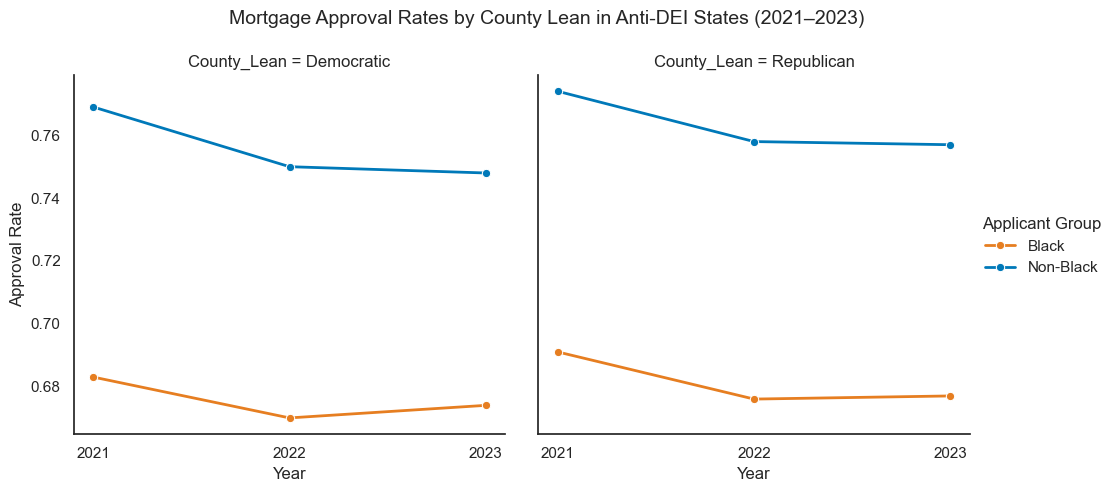

In [75]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Sample data
data = {
    'Year': [2021, 2022, 2023]*4,
    'Approval_Rate': [
        0.683, 0.670, 0.674,     
        0.691, 0.676, 0.677,     
        0.769, 0.750, 0.748,     
        0.774, 0.758, 0.757      
    ],
    'Applicant_Group': ['Black']*3 + ['Black']*3 + ['Non-Black']*3 + ['Non-Black']*3,
    'County_Lean': ['Democratic']*3 + ['Republican']*3 + ['Democratic']*3 + ['Republican']*3
}
df = pd.DataFrame(data)

palette = {
    'Black': '#E67E21',        
    'Non-Black': '#0079B9'    
}

sns.set(style="white")

g = sns.FacetGrid(df, col="County_Lean", hue="Applicant_Group", palette=palette, height=5, aspect=1)

g.map(sns.lineplot, "Year", "Approval_Rate", marker="o", linewidth=2)

for ax in g.axes.flat:
    ax.set_xticks([2021, 2022, 2023])
    ax.set_xticklabels(['2021', '2022', '2023'])
    ax.set_ylabel("Approval Rate")
    ax.set_xlabel("Year")
    ax.grid(False)

g.add_legend(title="Applicant Group")
plt.subplots_adjust(top=0.85)
g.fig.suptitle("Mortgage Approval Rates by County Lean in Anti-DEI States (2021–2023)", fontsize=14)

# Save plot to file
plt.savefig("approval_by_county_split.svg", dpi=300, bbox_inches='tight')
plt.show()


In [73]:
print(df.shape)
print(df.groupby(["County_Lean", "Applicant_Group", "Year"]).size())


(12, 4)
County_Lean  Applicant_Group  Year
Democratic   Black            2021    1
                              2022    1
                              2023    1
             Non-Black        2021    1
                              2022    1
                              2023    1
Republican   Black            2021    1
                              2022    1
                              2023    1
             Non-Black        2021    1
                              2022    1
                              2023    1
dtype: int64
